In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.style as style
import matplotlib.ticker as mtick
from lifelines import KaplanMeierFitter, CoxPHFitter
from IPython.display import display,Markdown, HTML
import geopandas
from scipy import stats
from sklearn.linear_model import LogisticRegression

style.use('fivethirtyeight')

/opt/anaconda3/envs/cse6242/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
d3 = pd.read_csv('sidewalks_311.csv',low_memory=False)
for col in [x for x in d3.columns if 'DATE' in x]:
    d3[col] = pd.to_datetime(d3[col])
    
d3['MO'] = d3['ADDDATE'] + pd.tseries.offsets.MonthBegin()

In [3]:
c2 = geopandas.read_file('Census_Blocks_in_2020.geojson')[['GEOID','geometry','P0010001']]\
    .rename(columns={'P0010001':'Total Population'})

## Note
The following analysis is an excerpt of data analysis as submitted to the DC Committee on Transportation & the Environment Annual Performance Oversight Hearing in **2022**.


## Summary
As a data analyst I took advantage of the great public data the city makes available through [Open Data DC](https://opendata.dc.gov/) to understand the impact of sidewalk requests and how they're completed.

I've found that:

 1. A non-insignificant amount of sidewalk tickets get closed without any work order being put in place and with likely no further update to the resident.
 2. Times to resolution even when a work order is being created is in excess of the established SLA.
 3. Times to closure within the 311 system appear to fall in advance of SLA deadlines.
 

## Data Results
In general sidewalk requests overtime have gone up from a 2013/2014 baseline and largely remained static with seasonal variability in terms of submissions to DC311.There's a large spike in submissions around 2014 but correspondingly have a large amount that are locked.


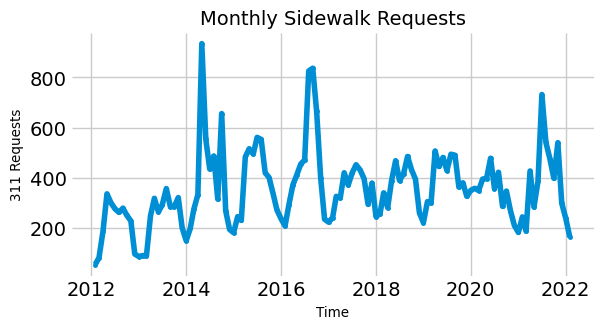

In [4]:
monthly_sidewalk_req = d3['MO'].dt.date.value_counts(dropna=False).sort_index()
fig = plt.figure(figsize=(6,3),dpi=100)
ax = fig.subplots()
ax.plot(monthly_sidewalk_req,label='311 Sidewalk Requests',markersize=5,marker='.')
ax.set_title('Monthly Sidewalk Requests',fontsize='medium')
ax.set_facecolor('white')
fig.set_facecolor('white')
ax.set_frame_on(False)
ax.set_ylabel("311 Requests",fontsize='x-small')
ax.set_xlabel('Time',fontsize='x-small')
plt.show()

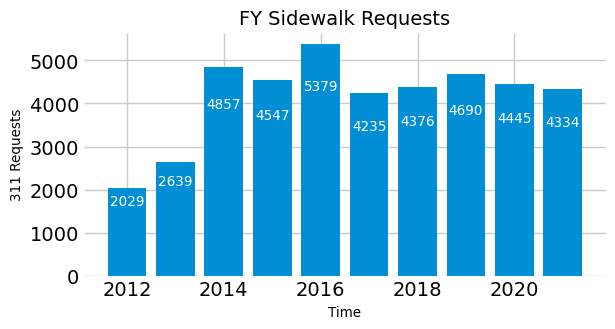

In [5]:
fy_sidewalk_requests = d3.query("FY <= 2021")['FY'].value_counts(dropna=False).sort_index()
fig = plt.figure(figsize=(6,3),dpi=100)
ax = fig.subplots()
ax.bar(fy_sidewalk_requests.index,fy_sidewalk_requests,label='311 Sidewalk Requests')
ax.set_title('FY Sidewalk Requests',fontsize='medium')
ax.set_facecolor('white')
fig.set_facecolor('white')
ax.set_frame_on(False)
ax.set_ylabel("311 Requests",fontsize='x-small')
ax.set_xlabel('Time',fontsize='x-small')
for v in fy_sidewalk_requests.index:
    ax.text(v,fy_sidewalk_requests[v]*.8,fy_sidewalk_requests[v],fontsize='x-small',ha='center',color='white')
plt.show()

In [6]:
aging_table = d3\
    .assign(D311_STATUS = lambda df: df['SERVICEORDERSTATUS'].apply(lambda x: 'OPEN' if x == 'OPEN' else 'CLOSED' if x == 'CLOSED' else 'OTHER'))\
    .pivot_table(index='FY',columns='D311_STATUS',values='D311_CNT',aggfunc=np.sum)\
    .assign(TOTAL=lambda df: df.sum(axis=1))

aging_table_mult = np.round(aging_table.div(aging_table['TOTAL'],axis=0) * 100,2)


/var/folders/4y/b7xlt7nn6w1b23t077hy3b_40000gn/T/ipykernel_23504/3535435170.py:1: FutureWarning: The provided callable <function sum at 0x7fa8107092d0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  aging_table = d3\


There is a substansial amount of open sidwalk repair tickets that have accumulated over the last 10 years with close to 9,958 open requests.

### Requests by Fiscal Year of Submission

In [7]:
display(aging_table)

D311_STATUS,CLOSED,OPEN,OTHER,TOTAL
FY,,,,
2012,1132,757,140,2029
2013,2171,461,7,2639
2014,3345,309,1203,4857
2015,3265,239,1043,4547
2016,4828,549,2,5379
2017,3579,653,3,4235
2018,3722,653,1,4376
2019,3406,1283,1,4690
2020,2804,1637,4,4445


### Requests by Fiscal Year of Submission as Percentage of Total FY

In [8]:
display(aging_table_mult)

D311_STATUS,CLOSED,OPEN,OTHER,TOTAL
FY,,,,
2012,55.79,37.31,6.90,100.0
2013,82.27,17.47,0.27,100.0
2014,68.87,6.36,24.77,100.0
2015,71.81,5.26,22.94,100.0
2016,89.76,10.21,0.04,100.0
2017,84.51,15.42,0.07,100.0
2018,85.05,14.92,0.02,100.0
2019,72.62,27.36,0.02,100.0
2020,63.08,36.83,0.09,100.0


The service level agreement for sidewalk repairs is **270 business days** which can result in over a **year of real time from when a problem is identified and when it's fixed.** 

### Examining time to request close

By utilizing a Kaplan Meier plot, we can visualize the timeline from submission to closure to understand the likelihood of a submission being completed by the SLA. 

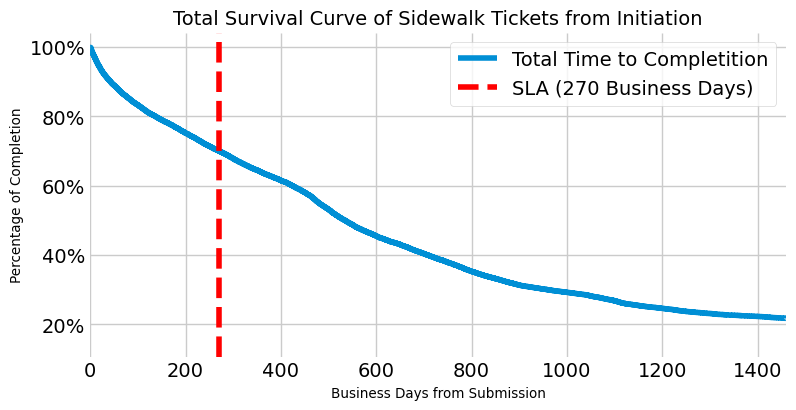

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(d3['EVENT_DAYS'],d3['EVENT_CLOSED'])
ax = kmf.plot(label='Total Time to Completition')
ax.set_title('Total Survival Curve of Sidewalk Tickets from Initiation',fontsize='medium')
ax.set_facecolor('white')
ax.set_ylabel('Percentage of Completion',fontsize='x-small')
ax.set_xlabel('Business Days from Submission',fontsize='x-small')
ax.axvline(270,label='SLA (270 Business Days)',color='red',linestyle='--')
ax.set_xlim([0,365*4])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
ax.legend(facecolor='white')
ax.figure.set_facecolor('white')
ax.figure.set_size_inches(8,4)
ax.set_frame_on(False)

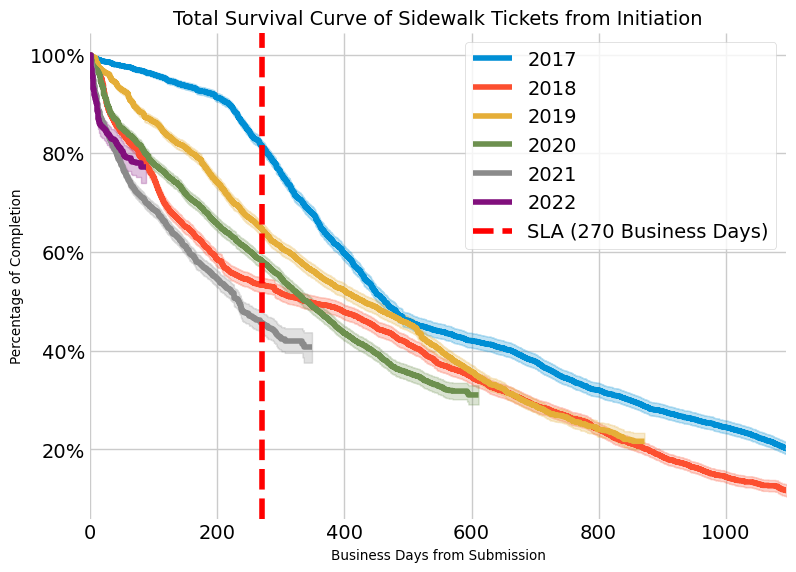

In [10]:
for fyi_i, fyg in d3.query("FY >= 2017").groupby('FY'):
    kmf = KaplanMeierFitter()
    kmf.fit(fyg['EVENT_DAYS'],fyg['EVENT_CLOSED'])
    ax= kmf.plot(label=fyi_i)

ax.set_title('Total Survival Curve of Sidewalk Tickets from Initiation',fontsize='medium')
ax.set_facecolor('white')
ax.set_ylabel('Percentage of Completion',fontsize='x-small')
ax.set_xlabel('Business Days from Submission',fontsize='x-small')
ax.set_xlim([0,365*3])

ax.figure.set_facecolor('white')
ax.figure.set_size_inches(8,6)
ax.axvline(270,label='SLA (270 Business Days)',color='red',linestyle='--')
ax.legend(facecolor='white')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
ax.set_frame_on(False)
plt.show()
    

In the above plot we can see the percentage of tickets are getting closed successively faster each FY as the SLA deadline approaches, but is it netting in actual fixed sidewalks?

### Mapping requests to work being done
By utilizing and combining the CityWorks work order management system and pairing it with sidewalks request within the open period we are able to attempt to delineate how many requests actually netted in having a work order to repair the underlying issue even if the initial service request is being closed.


In [11]:
closed_pvt = d3\
    .query("SERVICEORDERSTATUS == 'CLOSED'")\
    .pivot_table(index='D311_CLOSED_NO_WO',columns='FY',values='D311_CNT',aggfunc=np.sum)\
    .reset_index()\
    .assign(Closed=lambda df: df['D311_CLOSED_NO_WO'].apply(lambda x: 'Closed without Work Order' if x == 1 else 'Closed with Work Order'))\
    .set_index('Closed')\
    .drop('D311_CLOSED_NO_WO',axis=1)\
    .T\
    .assign(Total=lambda df: df.sum(axis=1))

closed_pvt_mult = np.round(closed_pvt.div(closed_pvt['Total'],axis=0)*100,2)


/var/folders/4y/b7xlt7nn6w1b23t077hy3b_40000gn/T/ipykernel_23504/13016404.py:1: FutureWarning: The provided callable <function sum at 0x7fa8107092d0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  closed_pvt = d3\


### Closed Requests by FY by Work Order Submission

In [12]:
display(closed_pvt)

Closed,Closed with Work Order,Closed without Work Order,Total
FY,,,
2012,529,603,1132
2013,971,1200,2171
2014,1562,1783,3345
2015,1353,1912,3265
2016,1725,3103,4828
2017,799,2780,3579
2018,1158,2564,3722
2019,2285,1121,3406
2020,1488,1316,2804


### Closed Requests by FY by Work Order Submission as Percentage of Total FY

In [13]:
display(closed_pvt_mult)

Closed,Closed with Work Order,Closed without Work Order,Total
FY,,,
2012,46.73,53.27,100.0
2013,44.73,55.27,100.0
2014,46.70,53.30,100.0
2015,41.44,58.56,100.0
2016,35.73,64.27,100.0
2017,22.32,77.68,100.0
2018,31.11,68.89,100.0
2019,67.09,32.91,100.0
2020,53.07,46.93,100.0


The takeaway is it appears that while progress is being made on closing tickets while working to address the issue there is still opportunity for improvement in resolving these problems.

We can visualize how these impacts certain parts of the city more acutely by scaling the number of incidents that highlights larger number of these within the historic Georgetown and central business district but a problem that pervades all parts of the city.


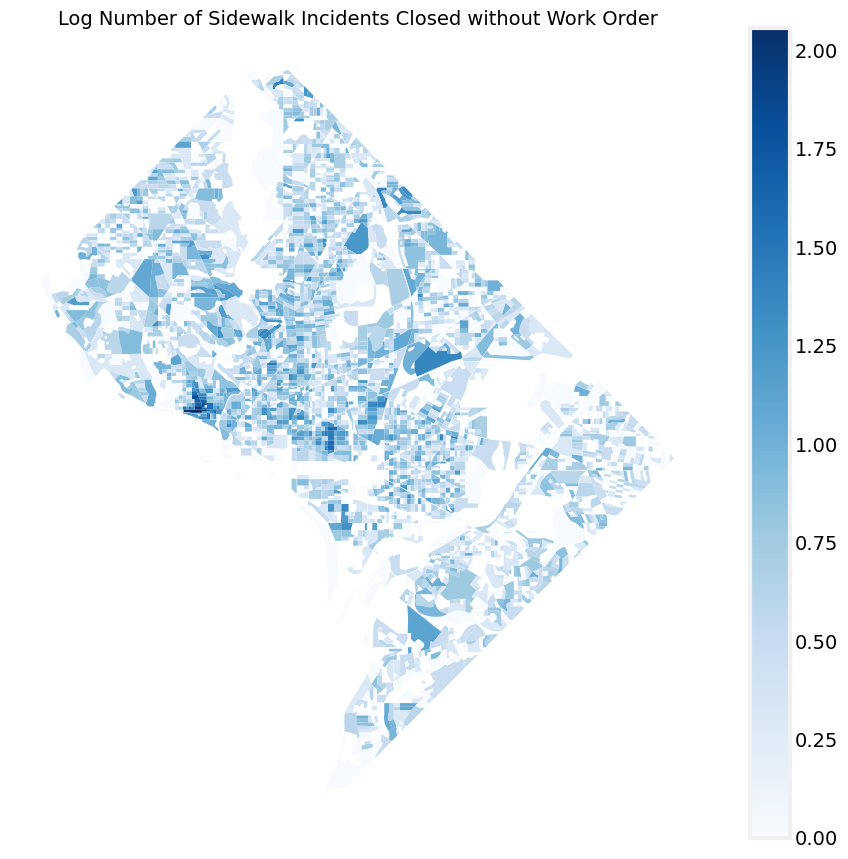

In [14]:
closed_no_wo = d3.query("D311_CLOSED_NO_WO == 1")

closed_map = c2.merge(closed_no_wo.groupby('GEOID')['D311_CNT'].sum(),how='left',on='GEOID')\
    .assign(LG = lambda df: np.log10(df['D311_CNT']))

ax = closed_map.plot(column='LG',cmap='Blues',legend=True)

ax.figure.set_facecolor('white')
ax.figure.set_size_inches(10,10)
ax.set_facecolor('white')
ax.axis('off')
ax.set_title('Log Number of Sidewalk Incidents Closed without Work Order',fontsize='medium')
plt.show()


By breaking out by individual wards we can examine some of the specific high impact corridors where tickets are closed without a work order being generated.

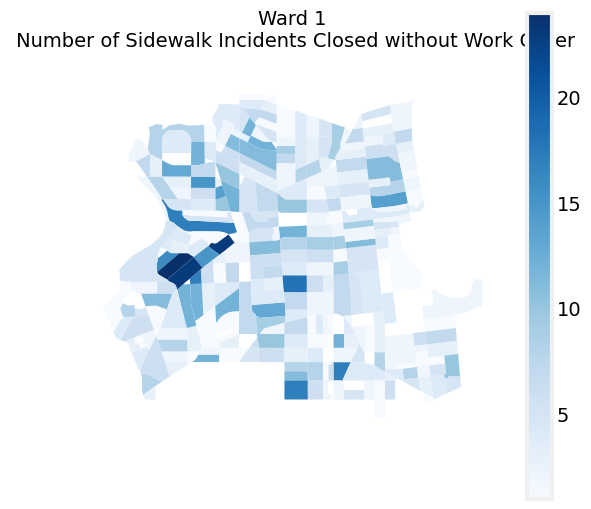

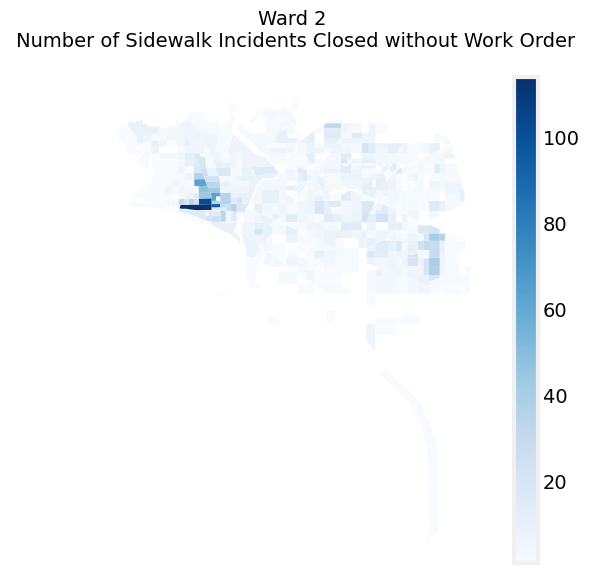

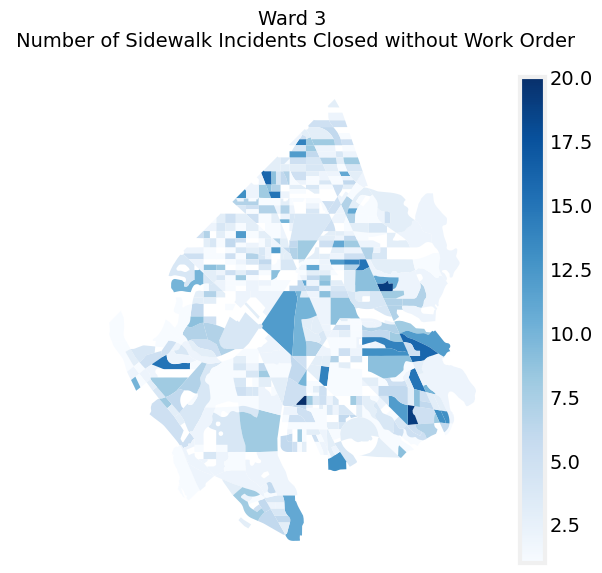

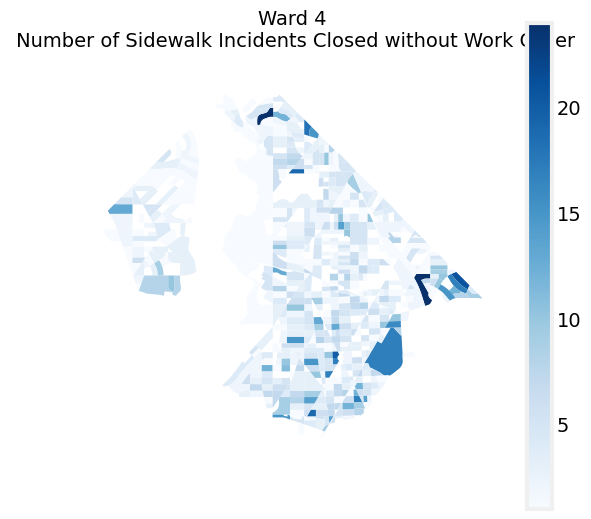

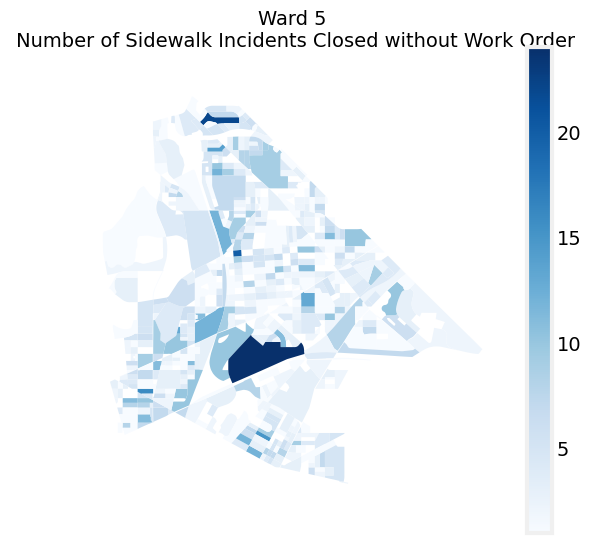

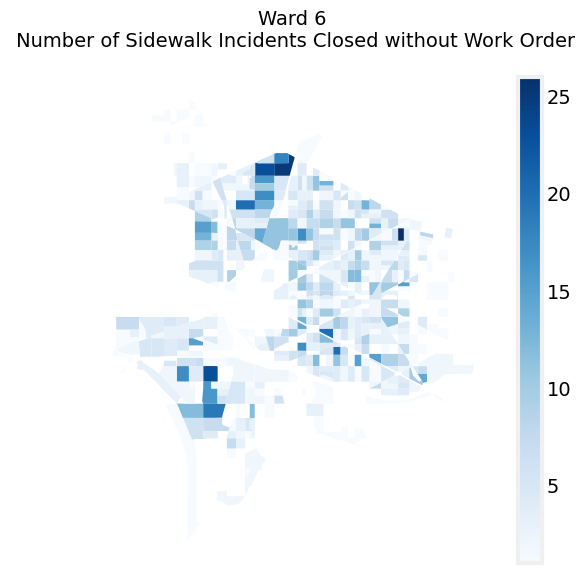

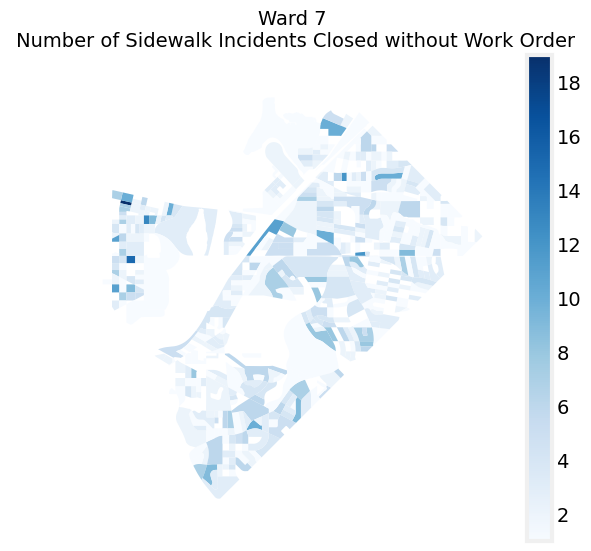

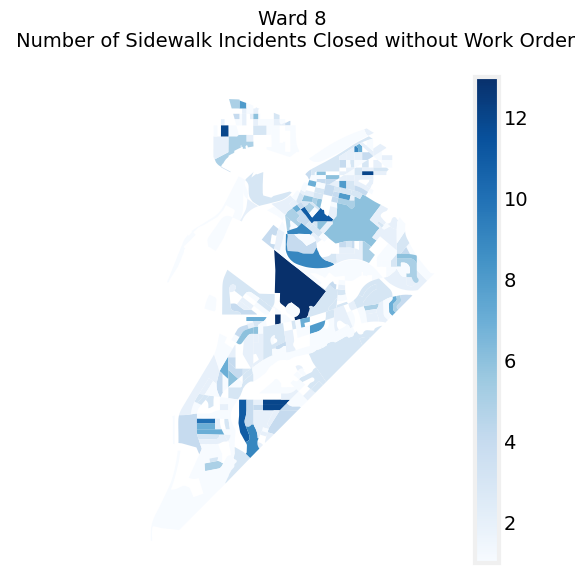

In [15]:
closed_no_wo = d3.query("D311_CLOSED_NO_WO == 1")

for wrd_i, wrd_grp in closed_no_wo.groupby('WARD'):

    closed_map = c2.merge(wrd_grp.groupby('GEOID')['D311_CNT'].sum(),how='left',on='GEOID')\
        .assign(LG = lambda df: np.log10(df['D311_CNT']))

    ax = closed_map.plot(column='D311_CNT',cmap='Blues',legend=True)

    ax.figure.set_facecolor('white')
    ax.figure.set_size_inches(6,6)
    ax.set_facecolor('white')
    ax.axis('off')
    ax.set_title(f'Ward {str(int(wrd_i))}\n Number of Sidewalk Incidents Closed without Work Order\n',fontsize='medium')
    plt.show()

When we examine those tickets that were closed and had a closed work order we can see that for older years the median value has come down by still largely remains above the SLA. It's worth noting that once we've experienced enough time from FY21/22 data whether the median business days to resolution will fall behind the SLA like previous FYs.

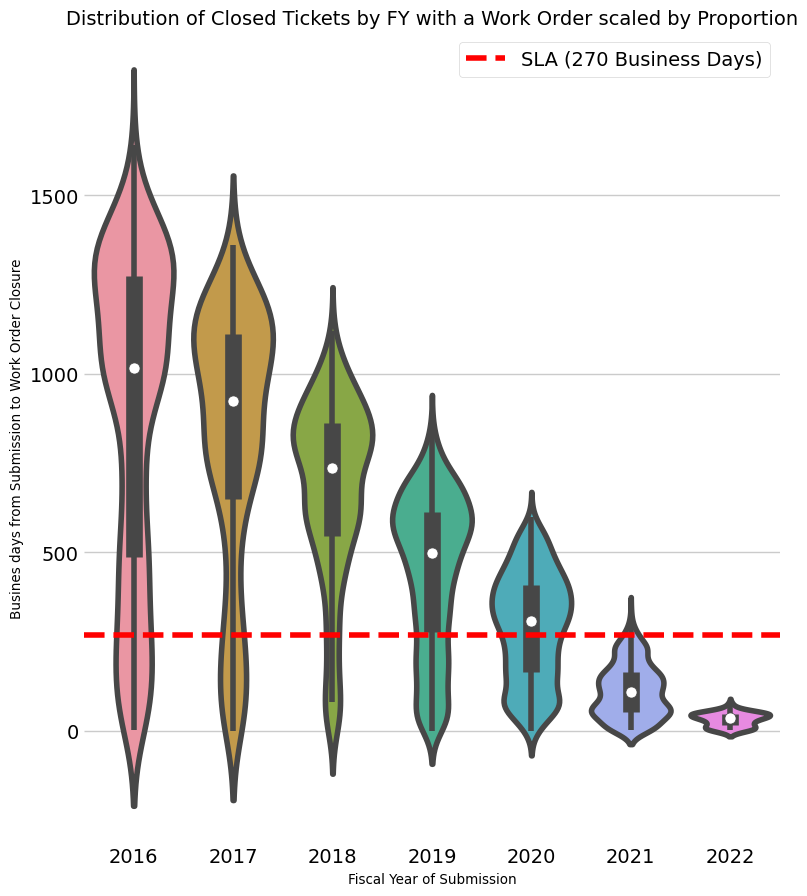

In [16]:
d3_complete = d3.query("SERVICEORDERSTATUS == 'CLOSED' and WO_CLOSED >= 1")
d3_chart = d3_complete.query("WO_EVENT_DAYS >= 0 and FY >= 2016")

ax = sns.violinplot(y=d3_chart['WO_EVENT_DAYS'],x=d3_chart['FY'],inner='box',scale='width')
ax.figure.set_facecolor('white')
ax.figure.set_size_inches(8,10)
ax.set_frame_on(False)
ax.set_facecolor('white')
ax.axhline(270,label='SLA (270 Business Days)',color='red',linestyle='--')
ax.set_title('Distribution of Closed Tickets by FY with a Work Order scaled by Proportion',fontsize='medium')
ax.set_ylabel('Busines days from Submission to Work Order Closure',fontsize='x-small')
ax.set_xlabel('Fiscal Year of Submission',fontsize='x-small')
ax.legend(facecolor='white')
plt.show()


### Examining the impact of Ward on Closure
Limiting our data to service requests from 2012-2019 that were closed we can observe the likelihood of a request being located in a ward that request in it being closed without a work order.

In [17]:
closed_lt = d3.query("SERVICEORDERSTATUS == 'CLOSED' and FY <= 2019")\
    .astype({'WARD':int})\
    .pivot_table(index='WARD',columns='D311_CLOSED_NO_WO',values='SERVICEREQUESTID',aggfunc=len)


stat, p, dof, expected = stats.chi2_contingency(closed_lt)

closed_table = closed_lt.rename(columns={1:'Closed without work order',0:'Closed with work order'}).assign(Total=lambda df: df.sum(axis=1))
display(closed_table)
display("Percentage closed by ward without work order")
display(np.round(closed_table.div(closed_table['Total'],axis=0)*100,2))
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')
    


D311_CLOSED_NO_WO,Closed with work order,Closed without work order,Total
WARD,,,
1,993,1245,2238
2,2707,3507,6214
3,1211,1875,3086
4,1566,2364,3930
5,1154,1836,2990
6,1411,2237,3648
7,878,1282,2160
8,462,720,1182


'Percentage closed by ward without work order'

D311_CLOSED_NO_WO,Closed with work order,Closed without work order,Total
WARD,,,
1,44.37,55.63,100.0
2,43.56,56.44,100.0
3,39.24,60.76,100.0
4,39.85,60.15,100.0
5,38.60,61.40,100.0
6,38.68,61.32,100.0
7,40.65,59.35,100.0
8,39.09,60.91,100.0


p value is 1.2616015678326343e-08
Dependent (reject H0)


We find that the p-value is significant and that we can reject the null hypothesis that the ward is not independent of a request being closed without a work order.

### Conclusion
There is room for improvement and investment in our city's sidewalks. Further, there is room to examine how the city utilizes the 311 system, the data it collects, and service resolution status to identify areas in which requests are closed prior or without any work being done.
